# A Road to Frictionless Urban Science: `osmnx` & `cenpy`. 

In [1]:
import cenpy
import osmnx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tuc_graph = osmnx.graph_from_place('Austin, TX')

In [3]:
tuc_data = cenpy.products.ACS().from_place('Austin, TX', 
                                           variables=['B02001_001E', 'B02001_003E'])

/home/lw17329/Dropbox/dev/cenpy/cenpy/geoparser.py:214: UserWarning: Shape is invalid: 
Ring Self-intersection[-10884881.1468 3554135.7868]
  tell_user('Shape is invalid: \n{}'.format(vexplain))


Matched: Austin, TX to Austin city within layer Incorporated Places


In [4]:
tuc_graph

In [5]:
tuc_data.head()

,GEOID,geometry,B02001_001E,B02001_003E,state,county,tract
0,48453002003,"POLYGON ((-10885870.78 3531403.57, -10885801.9...",4061.0,238.0,48,453,002003
1,48453001307,"POLYGON ((-10884436.87 3532796.35, -10884432.4...",3775.0,316.0,48,453,001307
2,48453001200,"POLYGON ((-10883885.28 3538771.92, -10883869.8...",4972.0,70.0,48,453,001200
3,48453002419,"POLYGON ((-10883764.28 3528065.19, -10883691.4...",4773.0,749.0,48,453,002419
4,48453001401,"POLYGON ((-10881722.01 3534812.03, -10881693.0...",3360.0,80.0,48,453,001401


In [6]:
tuc_nodes, tuc_streets  = osmnx.graph_to_gdfs(tuc_graph)

In [7]:
tuc_streets = tuc_streets.to_crs(epsg=3857)

Text(0.5, 1.0, 'Austin, TX\nAfrican American %')

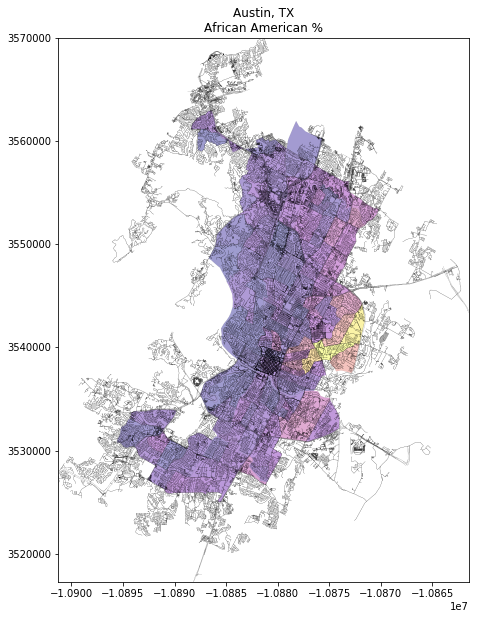

In [9]:
f,ax = plt.subplots(1,1, figsize=(10,10))
tuc_data.eval('pct_afam = B02001_003E / B02001_001E')\
        .plot('pct_afam', cmap='plasma', alpha=.4, ax=ax, linewidth=.1, edgecolor='k')
tuc_streets.plot(linewidth=.1, ax=ax, color='k')
ax.axis(tuc_streets.total_bounds[[0,2,1,3]])
ax.set_title('Austin, TX\nAfrican American %')